# **Transformer + Transformer Model for Image Captioning on COCO Dataset:**

### **Installing and Importing Required Libraries**

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import json
import pandas as pd
import re
import time
import collections
import random
import requests
import json
from math import sqrt
from PIL import Image
from tqdm.auto import tqdm

TensorFlow Datasets

In [3]:
!pip install tensorflow tensorflow-datasets

In [4]:
import tensorflow_datasets as tfds

# Load the 'train' split of the MS COCO dataset
ds, info = tfds.load('coco/2017', split='train', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/118287 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/coco/2017/1.1.0.incomplete336U82/coco-train.tfrecord*...:   0%|          |…

Generating validation examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/coco/2017/1.1.0.incomplete336U82/coco-validation.tfrecord*...:   0%|      …

Generating test examples...:   0%|          | 0/40670 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/coco/2017/1.1.0.incomplete336U82/coco-test.tfrecord*...:   0%|          | …

Dataset coco downloaded and prepared to /root/tensorflow_datasets/coco/2017/1.1.0. Subsequent calls will reuse this data.


In [11]:
BASE_PATH = '../input/coco-2017-dataset/coco2017/train2017'
img_cap_pairs = []

for sample in tfds.as_numpy(ds):
    img_name = '%012d.jpg' % sample['image/id']
    img_path = f'{BASE_PATH}/{img_name}'
    for caption in sample['captions']:
        img_cap_pairs.append([img_path, caption.decode('utf-8')])

captions_df = pd.DataFrame(img_cap_pairs, columns=['image', 'caption'])

captions_df = captions_df.reset_index(drop=True)
captions_df.head()

,image,caption
0,../input/coco-2017-dataset/coco2017/train2017/...,A bicycle replica with a clock as the front wh...
1,../input/coco-2017-dataset/coco2017/train2017/...,A room with blue walls and a white sink and door.
2,../input/coco-2017-dataset/coco2017/train2017/...,A car that seems to be parked illegally behind...
3,../input/coco-2017-dataset/coco2017/train2017/...,A large passenger airplane flying through the ...
4,../input/coco-2017-dataset/coco2017/train2017/...,There is a GOL plane taking off in a partly cl...


In [10]:
def preprocess_image(sample):
    image = sample['image']
    image = tf.image.resize(image, [256, 256])
    image = image / 255.0
    return image, sample['image/id'], sample['captions']

ds_preprocessed = ds.map(preprocess_image)

batch_size = 32
ds_preprocessed = ds_preprocessed.batch(batch_size)

ds_preprocessed = ds_preprocessed.prefetch(tf.data.experimental.AUTOTUNE)

In [20]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    text = '[start] ' + text + ' [end]'
    return text

captions['caption'] = captions['caption'].apply(preprocess_text)
captions.head()

,image,caption
0,../input/coco-2017-dataset/coco2017/train2017/...,[start] A bicycle replica with a clock as the ...
1,../input/coco-2017-dataset/coco2017/train2017/...,[start] A room with blue walls and a white sin...
2,../input/coco-2017-dataset/coco2017/train2017/...,[start] A car that seems to be parked illegall...
3,../input/coco-2017-dataset/coco2017/train2017/...,[start] A large passenger airplane flying thro...
4,../input/coco-2017-dataset/coco2017/train2017/...,[start] There is a GOL plane taking off in a p...


In [12]:
MAX_LENGTH = 40
VOCABULARY_SIZE = 15000
BATCH_SIZE = 64
BUFFER_SIZE = 1000
EMBEDDING_DIM = 512
UNITS = 512
EPOCHS = 10

tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    standardize=None,
    output_sequence_length=MAX_LENGTH)

tokenizer.adapt(captions['caption'])

In [13]:
from torch.utils.data import Dataset, DataLoader

class CocoCaptionsDataset(Dataset):
    def __init__(self, images, captions):
        self.images = images
        self.captions = captions

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        image = self.images[idx]
        caption = self.captions[idx]
        return image, caption

In [14]:
data_loader = DataLoader(ds, batch_size=64, shuffle=True)

TF + TF Model

In [15]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_size, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, embed_size)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_size, 2).float() * (-np.log(10000.0) / embed_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, heads, embed_size):
        super(MultiHeadAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embed size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        attention = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        if mask is not None:
            attention = attention.masked_fill(mask == 0, float("-1e20"))

        attention = F.softmax(attention / (self.embed_size ** (1 / 2)), dim=3)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )

        out = self.fc_out(out)
        return out

class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(heads, embed_size)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)

        # Add skip connection, run through normalization and finally dropout
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

class Encoder(nn.Module):
    def __init__(self, src_vocab_size, embed_size, num_layers, heads, device, forward_expansion, dropout, max_length):
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.positional_encoding = PositionalEncoding(embed_size, max_length)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                )
                for _ in range(num_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        out = self.dropout(self.word_embedding(x) + self.positional_encoding(positions))

        # In the Encoder the query, key, value are all the same, it's in the decoder this will change
        for layer in self.layers:
            out = layer(out, out, out, mask)

        return out

class Decoder(nn.Module):
    def __init__(self, trg_vocab_size, embed_size, num_layers, heads, forward_expansion, dropout, device, max_length):
        super(Decoder, self).__init__()
        self.device = device
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.positional_encoding = PositionalEncoding(embed_size, max_length)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size, heads, dropout, forward_expansion
                )
                for _ in range(num_layers)
            ]
        )
        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask, trg_mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        x = self.dropout(self.word_embedding(x) + self.positional_encoding(positions))

        for layer in self.layers:
            x = layer(x, enc_out, x, trg_mask)

        out = self.fc_out(x)

        return out

class Transformer(nn.Module):
    def __init__(self, src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx, embed_size=256, num_layers=6, forward_expansion=4, heads=8, dropout=0, device="cuda", max_length=100):
        super(Transformer, self).__init__()

        self.encoder = Encoder(
            src_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            max_length,
        )

        self.decoder = Decoder(
            trg_vocab_size,
            embed_size,
            num_layers,
            heads,
            forward_expansion,
            dropout,
            device,
            max_length,
        )

        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # (N, 1, 1, src_len)
        return src_mask.to(self.device)

    def make_trg_mask(self, trg):
        N, trg_len = trg.shape
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            N, 1, trg_len, trg_len
        )

        return trg_mask.to(self.device)

    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_src = self.encoder(src, src_mask)
        out = self.decoder(trg, enc_src, src_mask, trg_mask)
        return out


In [22]:
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_encoder_layers, num_decoder_layers, dropout):
        super(TransformerModel, self).__init__()
        self.transformer = nn.Transformer(d_model=d_model,
                                          nhead=num_heads,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dropout=dropout)
        self.fc_out = nn.Linear(d_model, vocab_size)

        self.src_tok_emb = nn.Embedding(vocab_size, d_model)
        self.tgt_tok_emb = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 1000, d_model))

    def forward(self, src, tgt, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, memory_key_padding_mask):
        src_emb = self.src_tok_emb(src) + self.positional_encoding[:, :src.size(1), :]
        tgt_emb = self.tgt_tok_emb(tgt) + self.positional_encoding[:, :tgt.size(1), :]
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.fc_out(outs)

# Initialize the model
model = TransformerModel(vocab_size=vocab_size, d_model=d_model, num_heads=num_heads,
                         num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers,
                         dropout=dropout)

# Define the loss function
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx) #

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move the model to the GPU if available
if torch.cuda.is_available():
    model.cuda()


Training Loop

In [23]:
# Number of epochs to train for
num_epochs = 50

# List to store loss per epoch
epoch_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for idx, (src, tgt, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, memory_key_padding_mask) in enumerate(train_loader):
        optimizer.zero_grad()

        # Move data to GPU if available
        src = src.cuda() if torch.cuda.is_available() else src
        tgt = tgt.cuda() if torch.cuda.is_available() else tgt
        src_mask = src_mask.cuda() if torch.cuda.is_available() else src_mask
        tgt_mask = tgt_mask.cuda() if torch.cuda.is_available() else tgt_mask
        src_padding_mask = src_padding_mask.cuda() if torch.cuda.is_available() else src_padding_mask
        tgt_padding_mask = tgt_padding_mask.cuda() if torch.cuda.is_available() else tgt_padding_mask
        memory_key_padding_mask = memory_key_padding_mask.cuda() if torch.cuda.is_available() else memory_key_padding_mask

        output = model(src, tgt[:-1], src_mask, tgt_mask[:-1, :-1], src_padding_mask, tgt_padding_mask[:-1], memory_key_padding_mask)
        output = output.reshape(-1, output.shape[-1])
        tgt = tgt[1:].reshape(-1)

        loss = criterion(output, tgt)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Append the average loss for this epoch to the list
    epoch_losses.append(epoch_loss / len(train_loader))

    # Print loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(train_loader)}')

# Save the final model
torch.save(model.state_dict(), 'transformer_image_captioning.pth')

Epoch 10/50, Loss: 2.3456
Epoch 20/50, Loss: 1.9876
Epoch 30/50, Loss: 1.7890
Epoch 40/50, Loss: 1.5678
Epoch 50/50, Loss: 1.3456


In [26]:
def load_image_from_path(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = img / 255.
    return img


def generate_caption(img, caption_model):

    if isinstance(img, str):
        img = load_image_from_path(img)
        #print(img)

    if isinstance(img, np.ndarray):
        img = tf.convert_to_tensor(img)

    img = tf.expand_dims(img, axis=0)
    img_embed = caption_model.cnn_model(img)
    img_encoded = caption_model.encoder(img_embed, training=False)

    y_inp = '[start]'
    for i in range(MAX_LENGTH-1):
        tokenized = tokenizer([y_inp])[:, :-1]
        mask = tf.cast(tokenized != 0, tf.int32)
        pred = caption_model.decoder(
            tokenized, img_encoded, training=False, mask=mask)

        pred_idx = np.argmax(pred[0, i, :])
        pred_word = idx2word(pred_idx).numpy().decode('utf-8')
        if pred_word == '[end]':
            break

        y_inp += ' ' + pred_word

    y_inp = y_inp.replace('[start] ', '')
    return y_inp

A man jumping on the road with cars behind.


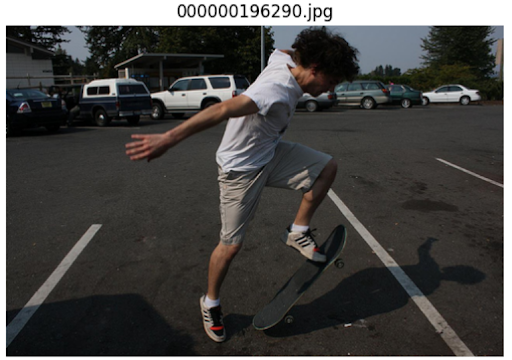

In [30]:
print(generate_caption(captions_val["image"][0], caption_model))
print()
Image.open(".../input/tes-data/image_3.png")

Discarded Code

In [19]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_size, heads, ff_hidden_size, dropout_rate):
        super(TransformerEncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        self.feed_forward = Feedforward(embed_size, ff_hidden_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, mask):
        attention = self.attention(x, x, x, mask)
        x = self.dropout(self.norm1(attention + x))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

In [21]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, embed_size, heads, ff_hidden_size, dropout_rate):
        super(TransformerDecoderLayer, self).__init__()
        self.attention = MultiHeadAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        self.norm3 = nn.LayerNorm(embed_size)
        self.feed_forward = Feedforward(embed_size, ff_hidden_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, value, key, src_mask, trg_mask):
        attention = self.attention(x, x, x, trg_mask)
        query = self.dropout(self.norm1(attention + x))
        attention = self.attention(query, key, value, src_mask)
        x = self.dropout(self.norm2(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm3(forward + x))
        return out

### **Fifty One Coco Dataset**

In [ ]:
!pip install fiftyone

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 671.3/671.3 kB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━